# Baseline
This notebook shows how I obtained my baseline results and graphs.

My baseline consists of trying out adaptive thresholding algorithms and improving upon them with binary morphology all using simpleitk.

Prerequisites to running this:
- Install dependencies from `environment.yml`
- Download the dataset or have the default subset in place.
- Generate the semantic segmentation masks using `instance2semantic.py`



In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import os
import copy
import tqdm

sitk2np = sitk.GetArrayViewFromImage

In [2]:
path = "dataset/images/livecell_train_val_{}/"
images_path = path.format("images")
masks_path = path.format("masks")

annot_path = "dataset/livecell_coco_train.json"

In [3]:
coco=COCO(annot_path)

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


In [4]:
val_images = [os.path.join(images_path, coco.loadImgs(x)[0]["file_name"]) for x in coco.getImgIds()]
val_masks = [os.path.join(masks_path, coco.loadImgs(x)[0]["original_filename"]) for x in coco.getImgIds()]

### Visualize a sample with its generated masks

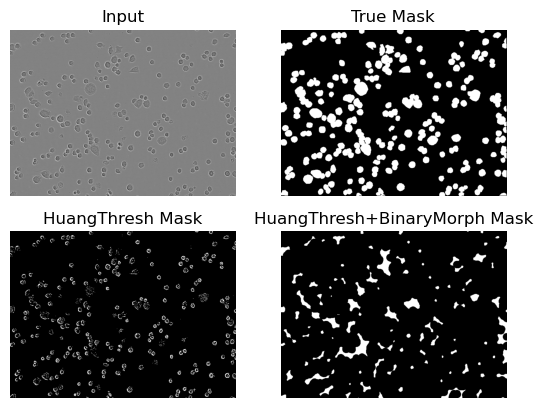

In [5]:
i = np.random.randint(len(val_images))
plt.subplot(2, 2, 1)
img = sitk.ReadImage(val_images[i])
plt.imshow(sitk2np(img), cmap="gray");plt.axis("off")
plt.title("Input")
plt.subplot(2, 2, 2)
plt.imshow(plt.imread(val_masks[i]), cmap="gray");plt.axis("off")
plt.title("True Mask")
plt.subplot(2, 2, 3)
thresh_filter = sitk.HuangThresholdImageFilter()
thresh_filter.SetInsideValue(1)
thresh_filter.SetOutsideValue(0)
thresh_img = thresh_filter.Execute(img)
plt.imshow(sitk2np(thresh_img), cmap="gray");plt.axis("off")
plt.title("HuangThresh Mask")

plt.subplot(2, 2, 4)
dilate_filter = sitk.BinaryDilateImageFilter()
dilate_filter.SetKernelRadius(9)
erode_filter = sitk.BinaryErodeImageFilter()
erode_filter.SetKernelRadius(11)
thresh_img = erode_filter.Execute(dilate_filter.Execute(thresh_img))
plt.imshow(sitk2np(thresh_img), cmap="gray");plt.axis("off")
plt.title("HuangThresh+BinaryMorph Mask")

plt.show()

### Instantiate adaptive threshholding algorithms

In [6]:
threshold_filters = {'Otsu': sitk.OtsuThresholdImageFilter(),
                     'Triangle' : sitk.TriangleThresholdImageFilter(),
                     'Huang' : sitk.HuangThresholdImageFilter(),
                     'MaxEntropy' : sitk.MaximumEntropyThresholdImageFilter()}

for filter_selection in threshold_filters.keys():
    thresh_filter = threshold_filters[filter_selection]
    thresh_filter.SetInsideValue(1)
    thresh_filter.SetOutsideValue(0)
    

overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

### Evaluate Adaptive thresholding

In [7]:
iou_results = {k: list() for k in threshold_filters.keys()}
dice_results = copy.deepcopy(iou_results)
thresh_results = copy.deepcopy(iou_results)

In [8]:
for i in tqdm.tqdm(range(len(val_images)), total=len(val_images)):
    img = sitk.ReadImage(val_images[i])
    mask = sitk.ReadImage(val_masks[i])>128
    for filter_selection in threshold_filters.keys():
        thresh_filter = threshold_filters[filter_selection]
        thresh_img = thresh_filter.Execute(img)
        thresh_value = thresh_filter.GetThreshold()

        overlap_measures_filter.Execute(mask, thresh_img)
        dice_results[filter_selection].append(overlap_measures_filter.GetDiceCoefficient())
        iou_results[filter_selection].append(overlap_measures_filter.GetJaccardCoefficient())
        thresh_results[filter_selection].append(thresh_value)
    

100%|██████████| 32/32 [00:01<00:00, 26.75it/s]


In [9]:
dice_results_reduced = {k: np.mean(v) for k,v in dice_results.items()}
iou_results_reduced = {k: np.mean(v) for k,v in iou_results.items()}

### Evaluate Adaptive thresholding + Binary Morphology

In [10]:
iou_results = {k: list() for k in threshold_filters.keys()}
dice_results = copy.deepcopy(iou_results)
thresh_results = copy.deepcopy(iou_results)

In [11]:
for i in tqdm.tqdm(range(len(val_images)), total=len(val_images)):
    img = sitk.ReadImage(val_images[i])
    mask = sitk.ReadImage(val_masks[i])>128
    for filter_selection in threshold_filters.keys():
        thresh_filter = threshold_filters[filter_selection]
        thresh_img = thresh_filter.Execute(img)
        thresh_value = thresh_filter.GetThreshold()
        dilate_filter = sitk.BinaryDilateImageFilter()
        dilate_filter.SetKernelRadius(9)
        erode_filter = sitk.BinaryErodeImageFilter()
        erode_filter.SetKernelRadius(11)
        thresh_img = erode_filter.Execute(dilate_filter.Execute(thresh_img))

        overlap_measures_filter.Execute(mask, thresh_img)
        dice_results[filter_selection].append(overlap_measures_filter.GetDiceCoefficient())
        iou_results[filter_selection].append(overlap_measures_filter.GetJaccardCoefficient())
        thresh_results[filter_selection].append(thresh_value)
    

100%|██████████| 32/32 [00:03<00:00,  9.19it/s]


In [12]:
dice_results_reduced_imp = {k: np.mean(v) for k,v in dice_results.items()}
iou_results_reduced_imp = {k: np.mean(v) for k,v in iou_results.items()}

### Visualize Results

Text(0.5, 1.0, 'Dice')

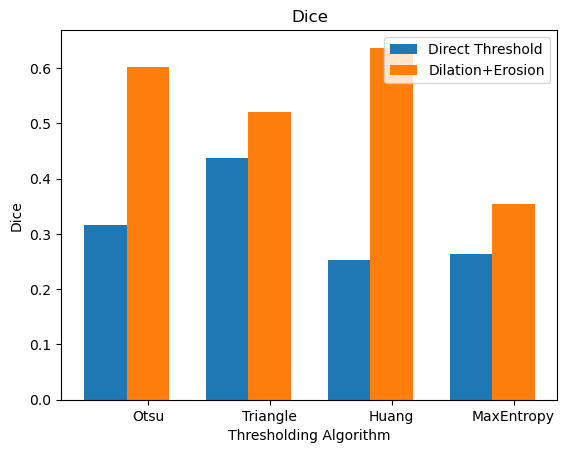

In [13]:
bar_width = 0.35
index = np.arange(len(dice_results))
plt.bar(index, dice_results_reduced.values(), bar_width, label="Direct Threshold")
plt.bar(index+bar_width, dice_results_reduced_imp.values(), bar_width, label="Dilation+Erosion")
plt.xticks(index + bar_width, dice_results_reduced.keys())
plt.legend()
plt.xlabel("Thresholding Algorithm")
plt.ylabel("Dice")
plt.title("Dice")

Text(0.5, 1.0, 'IoU')

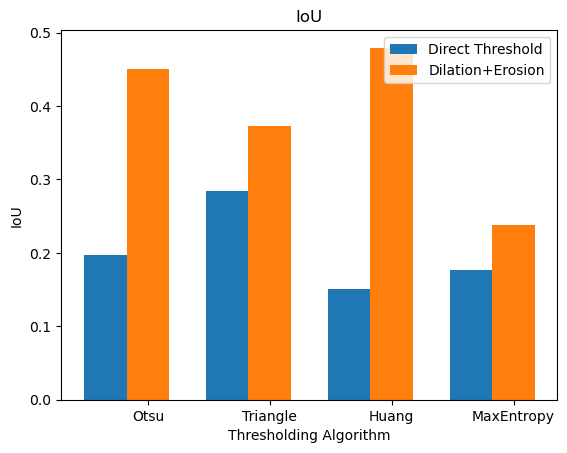

In [14]:
bar_width = 0.35
index = np.arange(len(dice_results))
plt.bar(index, iou_results_reduced.values(), bar_width, label="Direct Threshold")
plt.bar(index+bar_width, iou_results_reduced_imp.values(), bar_width, label="Dilation+Erosion")
plt.xticks(index + bar_width, dice_results_reduced.keys())
plt.legend()
plt.xlabel("Thresholding Algorithm")
plt.ylabel("IoU")
plt.title("IoU")